# Intro to Graph Convolutional Network

In [1]:
import numpy as np


In [2]:
adjacency_matrix = np.matrix('0,1,1,1;0,0,1,1;1,0,0,0;0,0,1,0',dtype=np.float32)
adjacency_matrix

matrix([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=float32)

In [3]:
feature_matrix = np.matrix('0,1,-1,0;5,3,2,1;1,0,0,0;1,1,0,0',dtype = np.float32)
feature_matrix

matrix([[ 0.,  1., -1.,  0.],
        [ 5.,  3.,  2.,  1.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  1.,  0.,  0.]], dtype=float32)

## Propagation


In [4]:
layer_0  = np.dot(adjacency_matrix,feature_matrix)
layer_0


matrix([[ 7.,  4.,  2.,  1.],
        [ 2.,  1.,  0.,  0.],
        [ 0.,  1., -1.,  0.],
        [ 1.,  0.,  0.,  0.]], dtype=float32)

## Including loops


In [5]:
identity = np.identity(adjacency_matrix.shape[0])
adjacency_matrix += identity
adjacency_matrix

matrix([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [1., 0., 1., 0.],
        [0., 0., 1., 1.]], dtype=float32)

## Normalization


In [6]:
d = np.array(np.sum(adjacency_matrix,axis = 1)).T[0]
d

array([4., 3., 2., 2.], dtype=float32)

In [7]:
diagonal_mat = np.diag(d)
diagonal_mat

array([[4., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]], dtype=float32)

In [8]:
inversed_diagonal_mat = np.linalg.inv(diagonal_mat)
inversed_diagonal_mat_half_symm = np.linalg.inv(diagonal_mat**0.5)
inversed_diagonal_mat_half_symm

array([[0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.57735026, 0.        , 0.        ],
       [0.        , 0.        , 0.70710677, 0.        ],
       [0.        , 0.        , 0.        , 0.70710677]], dtype=float32)

In [9]:
normalized_adj_mat = np.dot(inversed_diagonal_mat,adjacency_matrix)
normalized_adj_mat_half_symm = np.dot(inversed_diagonal_mat_half_symm,adjacency_matrix)
print("normalized_adj_mat_half_symm")
print(normalized_adj_mat_half_symm)
print("normalized_adj_mat_full_sym")
normalized_adj_mat_full_symm = inversed_diagonal_mat_half_symm*adjacency_matrix*inversed_diagonal_mat_half_symm
print(normalized_adj_mat_full_symm)

normalized_adj_mat_half_symm
[[0.5        0.5        0.5        0.5       ]
 [0.         0.57735026 0.57735026 0.57735026]
 [0.70710677 0.         0.70710677 0.        ]
 [0.         0.         0.70710677 0.70710677]]
normalized_adj_mat_full_sym
[[0.25       0.28867513 0.35355338 0.35355338]
 [0.         0.3333333  0.40824828 0.40824828]
 [0.35355338 0.         0.49999997 0.        ]
 [0.         0.         0.49999997 0.49999997]]


## Defining relu function

In [10]:
def relu(a):
    mask = a > 0
    return np.multiply(a,mask)

In [11]:
relu(inversed_diagonal_mat)

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.33333334, 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]], dtype=float32)

In [12]:
relu(np.matrix('-1,4,2,-1;-22,3,-1,1'))

matrix([[0, 4, 2, 0],
        [0, 3, 0, 1]])

 # PyTorch implementation

In [13]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes, to_numpy_matrix
from pandas import read_csv, Series
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Data preprocessing 

In [14]:
DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )
  
    X_train,y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
  
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
 
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [15]:
zkc = load_karate_club()
X_train_flattened = torch.flatten(torch.from_numpy(zkc.X_train))
X_test_flattened = torch.flatten(torch.from_numpy(zkc.X_test))
y_train = torch.from_numpy(zkc.y_train).to(torch.float)

print(y_train)
A = to_numpy_matrix(zkc.network)
A = torch.from_numpy(np.array(A))
print(A)
print(X_train_flattened)

tensor([1., 0.])
tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], dtype=torch.float64)
tensor([ 0, 33], dtype=torch.int32)


# SpectralRule and LogisticRegressor Modules

In [16]:
class SpectralRule(nn.Module):
    
    def __init__(self,A,input_units,output_units,activation = 'tanh'):
        
        super(SpectralRule,self).__init__()
        
        self.input_units = input_units
        self.output_units = output_units
        self.linear_layer = nn.Linear(self.input_units,self.output_units)
        nn.init.xavier_normal_(self.linear_layer.weight)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.Identity()
        #Created Identity Matrix
        I = torch.eye(A.shape[1])
       
        #Adding self loops to the adjacency matrix
        A_hat = A + I
        A_hat = A_hat.to(torch.double)
       
        #Inverse degree Matrix
        D = torch.diag(torch.pow(torch.sum(A_hat,dim = 0),-0.5),0)
       
        #applying spectral rule
        self.A_hat = torch.matmul(torch.matmul(D,A_hat),D)
        self.A_hat.requires_grad = False
       
        
    def forward(self,X):
        
        #aggregation
        aggregation = torch.matmul(self.A_hat,X)
         
        #propagation
        linear_output = self.linear_layer(aggregation.to(torch.float))
      
        propagation = self.activation(linear_output)
          
        return propagation.to(torch.double)

class LogisticRegressor(nn.Module):
    
    def __init__(self,input_units,output_units):
        super(LogisticRegressor,self).__init__()
        
        self.Linear = nn.Linear(input_units,output_units,bias=True)
        nn.init.xavier_normal_(self.Linear.weight)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,X):
        linear_output = self.Linear(X.to(torch.float))
        return self.sigmoid(linear_output)
        
            
            
        
        
        
        

# Building the Base Model

In [17]:
identity = torch.eye(A.shape[1])
identity = identity.to(torch.double)
identity.requires_grad = False

In [18]:
hidden_layer_config = [(4,'tanh'),(2,'tanh')]

class FeatureModel(nn.Module):
    def __init__(self,A,hidden_layer_config,initial_input_size):
        super(FeatureModel,self).__init__()
        
        self.hidden_layer_config = hidden_layer_config
        
        self.moduleList = list()
        
        self.initial_input_size = initial_input_size
        
        for input_size,activation in hidden_layer_config:
            
            self.moduleList.append(SpectralRule(A,self.initial_input_size,input_size,activation))
            self.initial_input_size = input_size
        
        
        
        self.sequentialModule = nn.Sequential(*self.moduleList)
      
           
    def forward(self,X):
        output = self.sequentialModule(X)
       
        return output

class ClassifierModel(nn.Module):
    def __init__(self,input_size,output_size):
        super(ClassifierModel,self).__init__()
        self.logisticRegressor = LogisticRegressor(input_units=input_size,output_units= output_size)
        
    def forward(self,X):
        
        classified  = self.logisticRegressor(X)
        return classified
    

class HybridModel(nn.Module):
    def __init__(self,A,hidden_layer_config,initial_input_size):
        super(HybridModel,self).__init__()
        self.featureModel = FeatureModel(A,hidden_layer_config,identity.shape[1])
        self.featureModelOutputSize = self.featureModel.initial_input_size
        self.classifier = ClassifierModel(self.featureModelOutputSize,1)
        self.featureModelOutput = None
    
    def forward(self,X):
        
        outputFeature = self.featureModel(X)
        classified = self.classifier(outputFeature)
        self.featureModelOutput = outputFeature
        return classified
        

# Identity Matrix as feature

In [19]:
model = HybridModel(A,hidden_layer_config,identity.shape[1])

output = model(identity)

In [20]:
zkc.y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False])

In [21]:
output

tensor([[0.4753],
        [0.4176],
        [0.3945],
        [0.3683],
        [0.3792],
        [0.4143],
        [0.4157],
        [0.3418],
        [0.3956],
        [0.3766],
        [0.3454],
        [0.3361],
        [0.3584],
        [0.3312],
        [0.3505],
        [0.3426],
        [0.4066],
        [0.3981],
        [0.3325],
        [0.4043],
        [0.3547],
        [0.4955],
        [0.4153],
        [0.5117],
        [0.3800],
        [0.3774],
        [0.3523],
        [0.3846],
        [0.3806],
        [0.3997],
        [0.4172],
        [0.3787],
        [0.4141],
        [0.3475]], grad_fn=<SigmoidBackward>)

# Train Model

In [22]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum=0.9)
featureoutput = None

def train(model , epoch , criterion , optimizer , feature):
    cumLoss = 0
    losses = list()
    
    for j in range(epoch): 
        two_loss = 0
        for i,node in enumerate(X_train_flattened):
           
            output = model(feature)[node]
            
            ground_truth = torch.reshape(y_train[i],output.shape)
            
            
            
            optimizer.zero_grad() 
            
            loss = criterion(output,ground_truth)
            #\print("loss: ",loss.data)
            two_loss += loss.item()
            
            loss.backward()
            
            optimizer.step()
        losses.append(two_loss)
        cumLoss += two_loss
    print('avg loss: ',cumLoss/epoch)
    torch.save(model.state_dict(),"./gcn.pth")
    plt.plot(losses)
    
   

avg loss:  0.005785782837687293


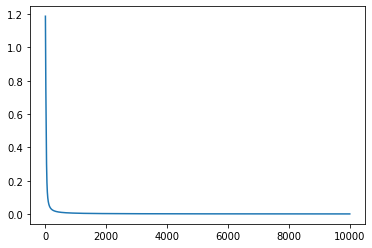

In [23]:
train(model,10000,criterion,optimizer,identity)

In [24]:
model.state_dict()


OrderedDict([('featureModel.sequentialModule.0.linear_layer.weight',
              tensor([[ 0.5463,  0.6542, -0.2333,  0.3842,  0.5791,  0.2090,  0.2434,  0.0127,
                       -0.2680,  0.3896,  0.2186,  0.1631,  0.2919, -0.3246, -0.0556, -0.1573,
                       -0.4211,  0.3313, -0.3623,  0.1321, -0.0385, -0.0583,  0.1372, -0.5186,
                        0.0525, -0.0879, -0.4883,  0.0519, -0.0803, -0.6776,  0.2349, -0.7329,
                        0.3391, -1.1530],
                      [-0.2196, -0.7535, -0.0713, -0.1234,  0.2665, -0.4115, -0.3841, -0.1055,
                       -0.2807, -0.0100,  0.0132, -0.1269,  0.2034, -0.0102,  0.1152, -0.1421,
                        0.2147, -0.2716,  0.3841, -0.0570,  0.1178,  0.0865, -0.3124,  0.4006,
                       -0.4131,  0.0762, -0.1623,  0.1430, -0.2656,  0.3507, -0.0432,  0.3673,
                       -0.2273,  1.2699],
                      [ 0.2768,  0.0714, -0.2562, -0.1322,  0.0884, -0.1609,  0.1375, -

In [25]:
X_test_flattened

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31, 30,  9,
        27, 28, 32, 16, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26],
       dtype=torch.int32)

In [26]:
after = None
def test(features):
    
    model = HybridModel(A,hidden_layer_config,identity.shape[1])
    model.load_state_dict(torch.load("./gcn.pth"))
    model.eval()
    correct = 0 
    masked_output = list()
    for i ,node in enumerate(X_test_flattened):
        output = model(features)[node]
        masked_output.append(output.ge(0.5))
    
    return masked_output  
        
        
    

In [27]:

masked = test(identity)
masked = [i.item() for i in masked]
masked

[True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False]

In [28]:
test_gt = torch.from_numpy(zkc.y_test)
test_gt = [ i.item() for i in test_gt]
test_gt
counter = 0
tp = 0
fp = 0
fn = 0
tn = 0

correct = zip(masked,test_gt)
for (masked,gt) in list(correct):
    if masked == gt and masked == True:
        tp += 1
    if masked == gt and masked == False:
        tn += 1
    if masked == False and gt == True:
        fn += 1
    if masked == True and gt == False:
        fp += 1
accuracy = (tp + tn) / (tp+fp+fn+tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print('accuracy ',accuracy)
print('precision ',precision)
print('recall ',recall)

accuracy  0.625
precision  0.7
recall  0.4375
